# Time Series Project #1: Google Stock Price Forecasting with TensorFlow

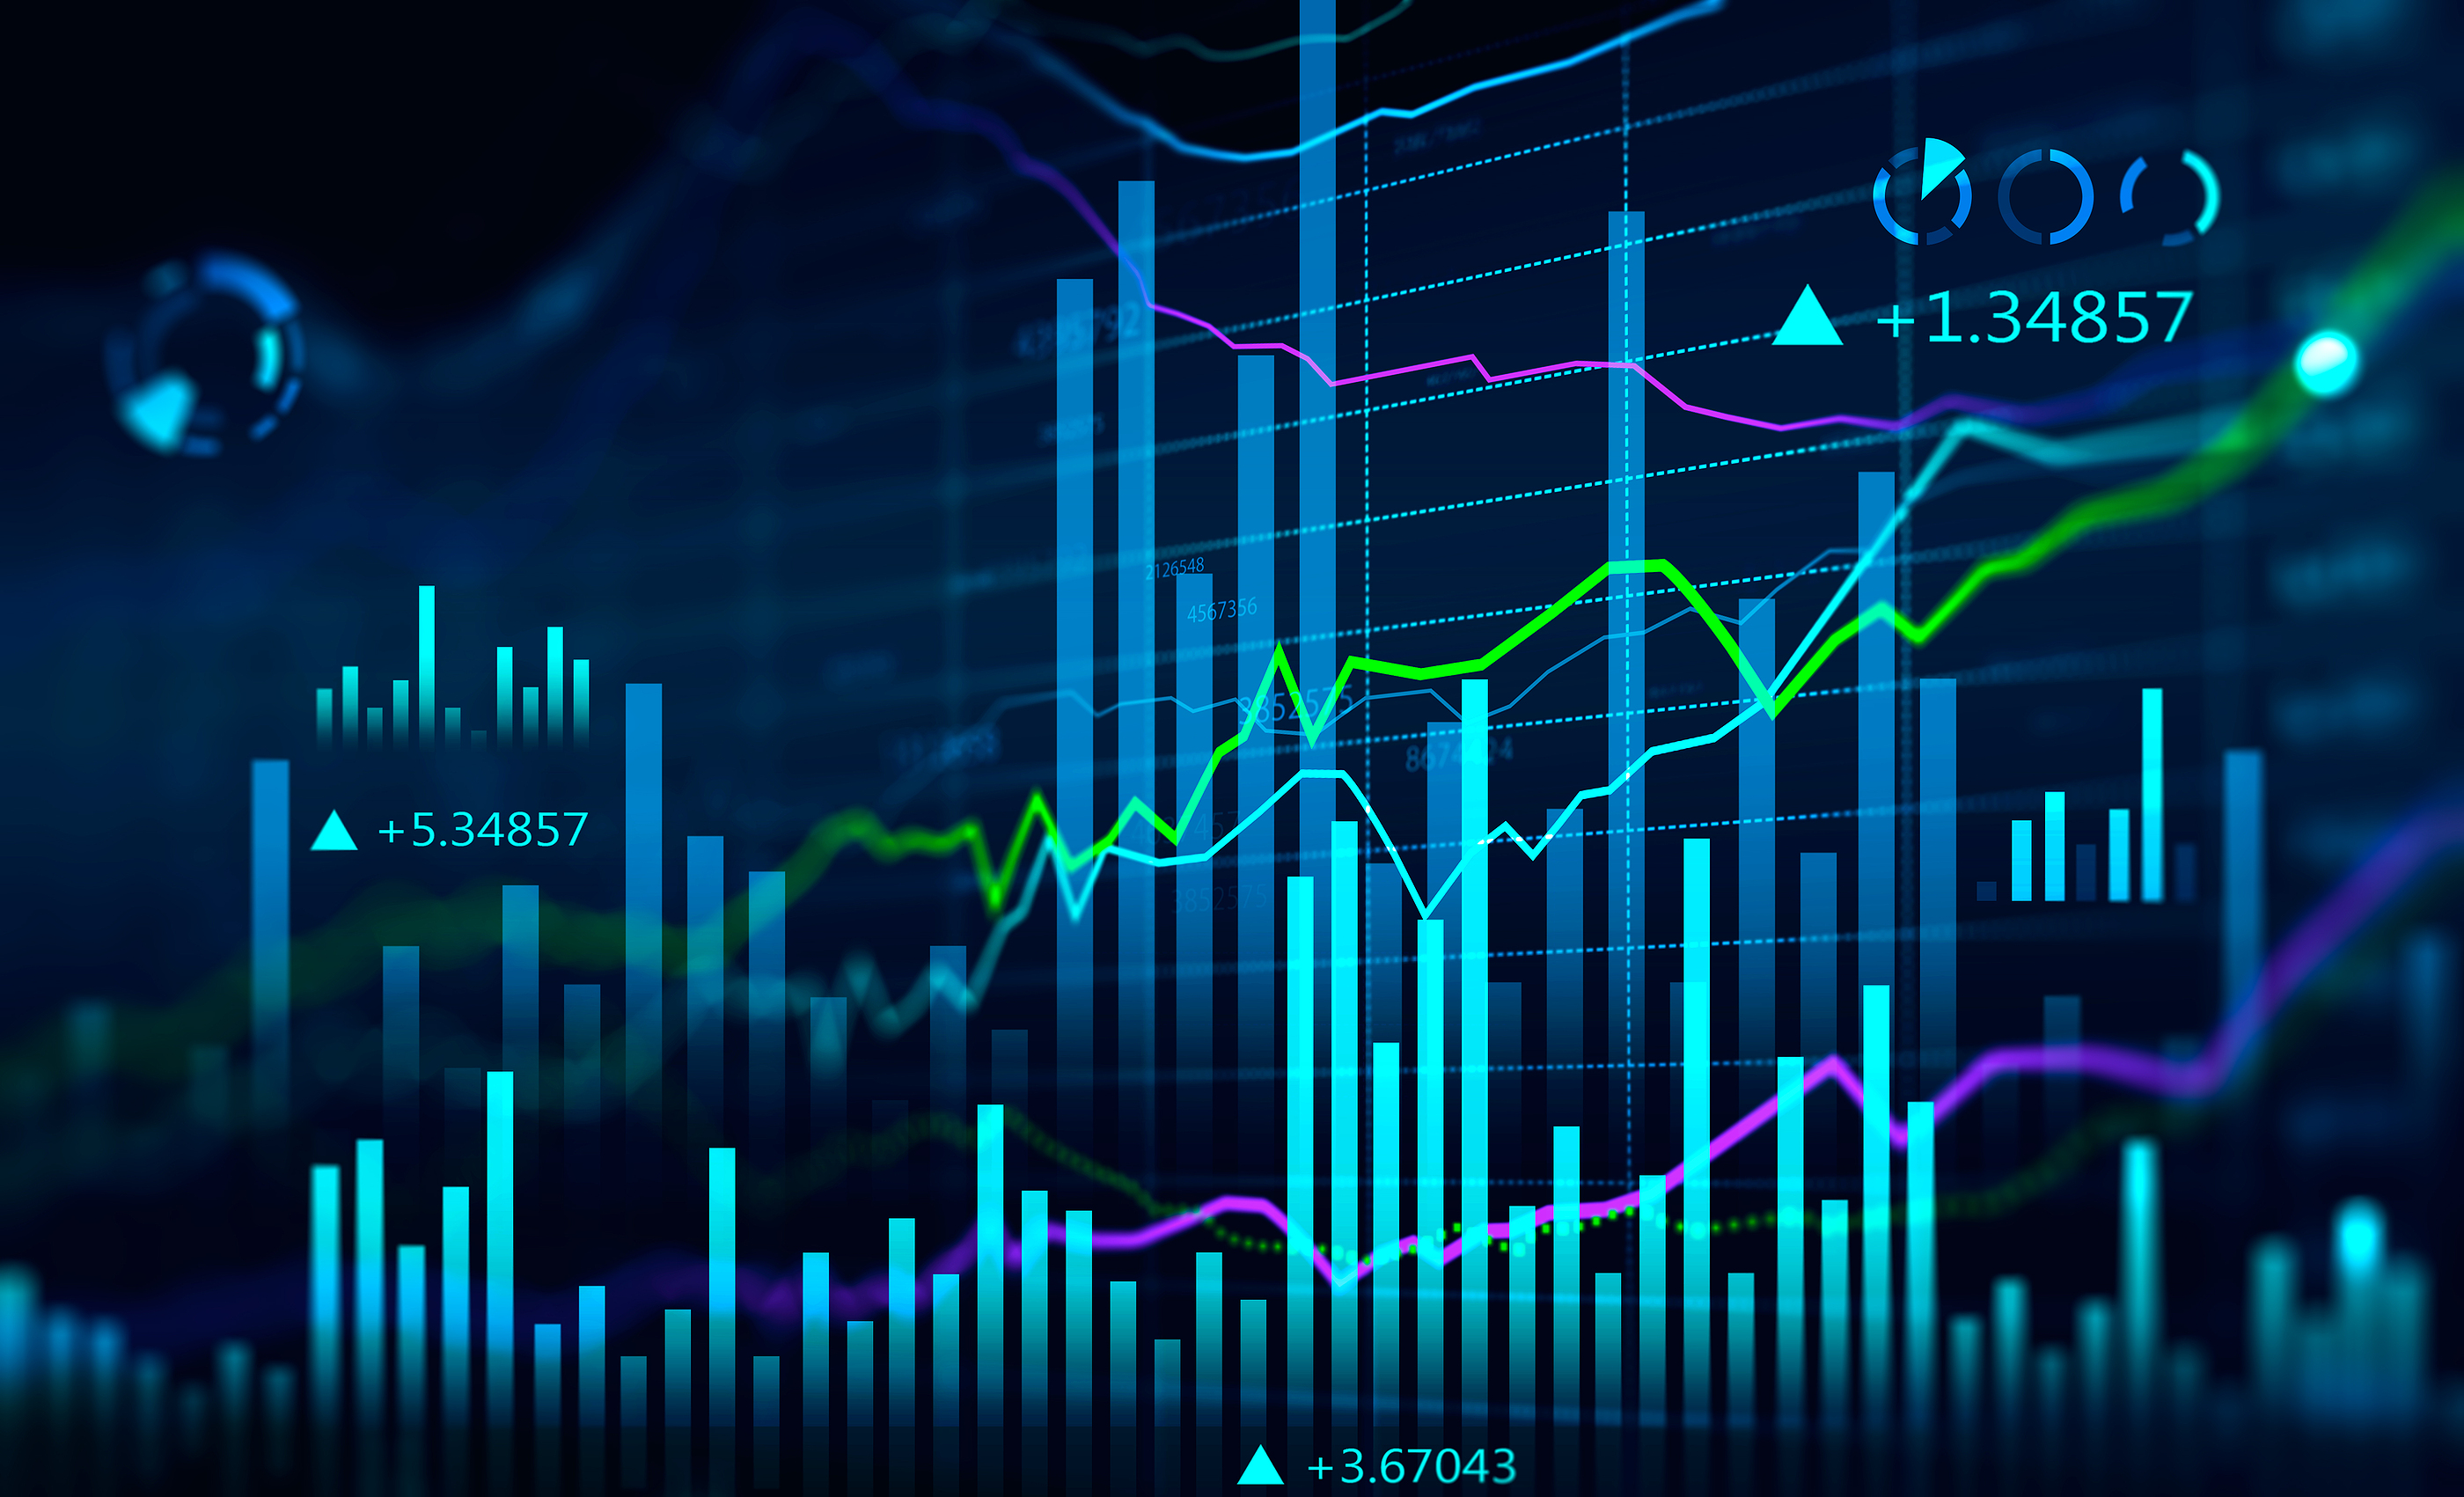

***
### Importing Dependencies

In [1]:
from tensorflow.keras.metrics import mean_squared_error, mean_absolute_error, mean_absolute_percentage_error
from tensorflow.keras.layers import GRU, LSTM, Input, Conv1D, Dense, Lambda, MaxPool1D, Bidirectional
from tensorflow.keras.models import load_model, clone_model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import mse
from tensorflow.keras import Model

from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from warnings import filterwarnings

import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
import pandas as pd
import numpy as np
import pickle
import os

In [2]:
sns.set(style = 'darkgrid', palette = 'bright')
pd.set_option('display.max_columns', None)
plt.rcParams['figure.figsize'] = (12, 8)
filterwarnings(action = 'ignore')

***
### Importing Dataset

In [3]:
raw = pd.read_csv(filepath_or_buffer = 'Data.csv')
df = raw.copy()
df.head()

Date       High        Low       Open      Close      Volume  \
0  2004-08-19  51.835709  47.800831  49.813290  49.982655  44871361.0   
1  2004-08-20  54.336334  50.062355  50.316402  53.952770  22942874.0   
2  2004-08-23  56.528118  54.321388  55.168217  54.495735  18342897.0   
3  2004-08-24  55.591629  51.591621  55.412300  52.239197  15319808.0   
4  2004-08-25  53.798351  51.746044  52.284027  52.802086   9232276.0   

   Adj Close  
0  49.982655  
1  53.952770  
2  54.495735  
3  52.239197  
4  52.802086

Let's get initial information about the data using descriptive statistics.

In [4]:
display(df.info(), df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4298 entries, 0 to 4297
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       4298 non-null   object 
 1   High       4298 non-null   float64
 2   Low        4298 non-null   float64
 3   Open       4298 non-null   float64
 4   Close      4298 non-null   float64
 5   Volume     4298 non-null   float64
 6   Adj Close  4298 non-null   float64
dtypes: float64(6), object(1)
memory usage: 235.2+ KB


None

High          Low         Open        Close        Volume  \
count  4298.000000  4298.000000  4298.000000  4298.000000  4.298000e+03   
mean    630.103779   618.210523   624.106143   624.358342  6.546994e+06   
std     544.175379   534.793760   539.047561   539.817047  7.839967e+06   
min      50.680038    47.800831    49.409801    49.818268  7.922000e+03   
25%     247.293083   241.098804   244.350361   244.029068  1.600700e+06   
50%     396.762833   390.531204   394.737930   394.329453  3.875974e+06   
75%     930.709229   917.917511   925.132477   924.817490  8.285390e+06   
max    2936.409912  2912.290039  2918.989990  2916.840088  8.254163e+07   

         Adj Close  
count  4298.000000  
mean    624.358342  
std     539.817047  
min      49.818268  
25%     244.029068  
50%     394.329453  
75%     924.817490  
max    2916.840088

Let's remove the potential extra spaces in columns, lower them and rename the **Close** variable as **target**.

In [5]:
print(f'Columns before: {df.columns}')

df.columns = df.columns.str.strip()
df.rename(columns = lambda x: x.lower(), inplace = True)
df.rename(columns = {'close':'target'}, inplace = True)

print(f'Columns now: {df.columns}')

Columns before: Index(['Date', 'High', 'Low', 'Open', 'Close', 'Volume', 'Adj Close'], dtype='object')
Columns now: Index(['date', 'high', 'low', 'open', 'target', 'volume', 'adj close'], dtype='object')


Let's cast the data type of **date** variable.

In [6]:
print(f'Data type of date variable before: {df.date.dtype}')

df['date'] = pd.to_datetime(df['date'], yearfirst = True)

print(f'Data type of date variable now: {df.date.dtype}')

Data type of date variable before: object
Data type of date variable now: datetime64[ns]


Let's visualize the historical closing price of Google shares.

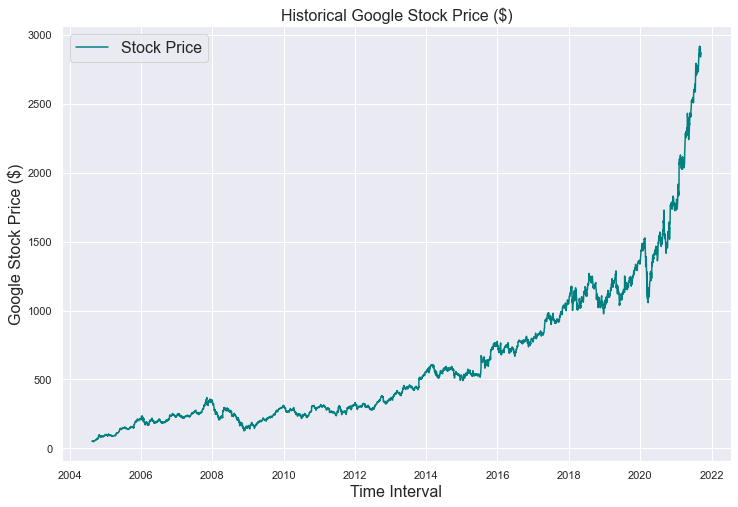

In [7]:
plt.plot(df['date'].values, df['target'].values, label = 'Stock Price', c = 'teal')
plt.title(label = 'Historical Google Stock Price ($)', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

***
### Data Preprocessing

Let's split the data set into features and labels in the form of numpy arrays. In addition, let's also cast the data type of **target** variable into **float32**.

In [8]:
X = df.date.to_numpy()
Y = df.target.to_numpy(dtype = np.float32)

Let's split the features and labels into train and validation sets.

In [9]:
X_train, X_valid, y_train, y_valid = train_test_split(X, Y, test_size = 0.2, shuffle = False)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3438,), (3438,), (860,), (860,))

Let's visualize the train and validation sets.

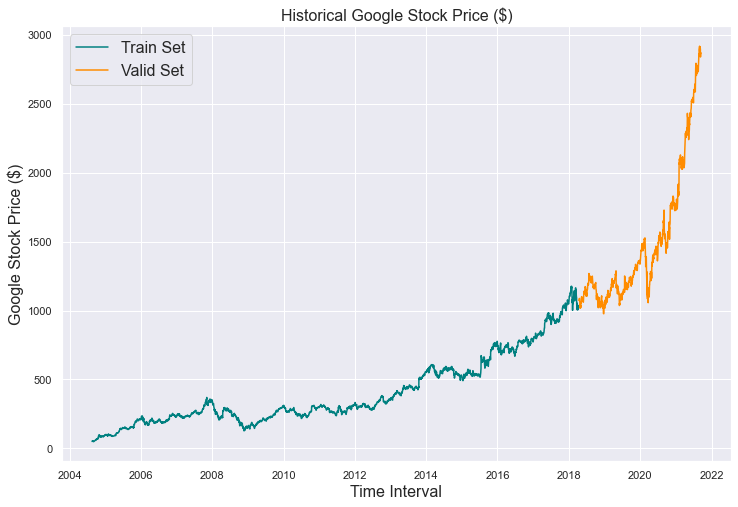

In [10]:
plt.plot(X_train, y_train, label = 'Train Set', c = 'teal')
plt.plot(X_valid, y_valid, label = 'Valid Set', c = 'darkorange')
plt.title(label = 'Historical Google Stock Price ($)', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

***
### Modelling: Naive Forecast Model

Let's build the first model which is **Naive Forecast**.

In [11]:
model_1_predictions = y_valid[:-1]

Let's visually compare the naive forecast predictions to ground truth values.

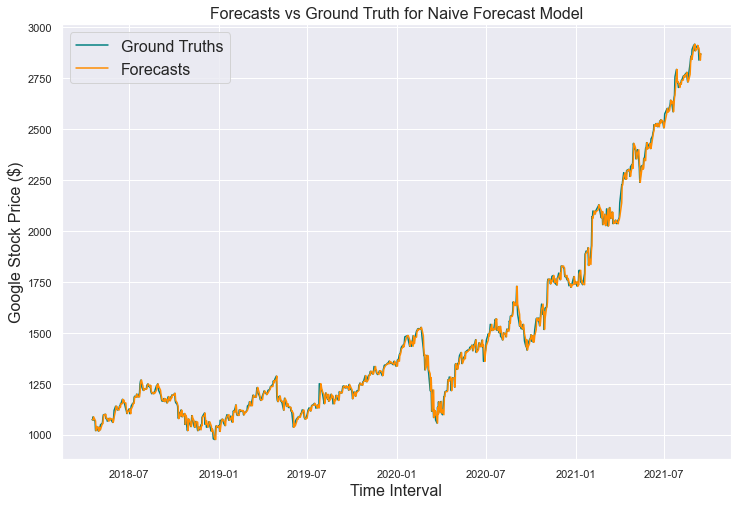

In [12]:
plt.plot(X_valid, y_valid, label = 'Ground Truths', c = 'teal')
plt.plot(X_valid[1:], model_1_predictions, label = 'Forecasts', c = 'darkorange')
plt.title(label = 'Forecasts vs Ground Truth for Naive Forecast Model', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

Let's zoom in to have better understanding visually about the performance.

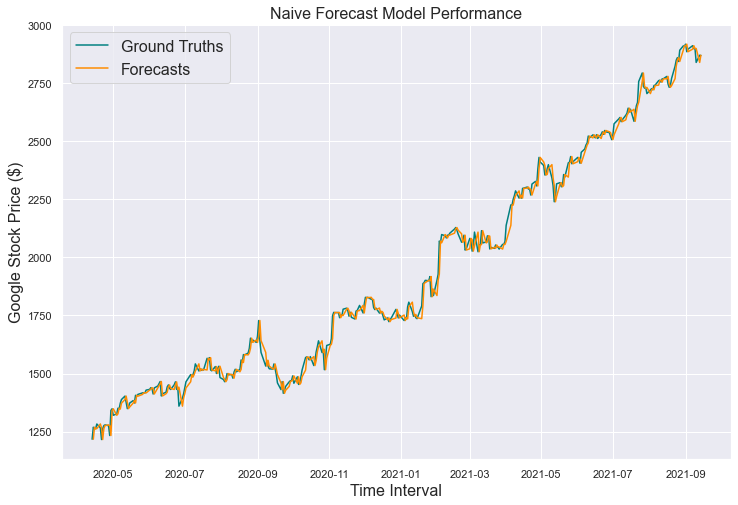

In [13]:
plt.plot(X_valid[500:], y_valid[500:], label = 'Ground Truths', c = 'teal')
plt.plot(X_valid[1:][500:], model_1_predictions[500:], label = 'Forecasts', c = 'darkorange')
plt.title(label = 'Naive Forecast Model Performance', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

Let's also compare randomly selected forecasts to ground truth values which are also randomly selected.

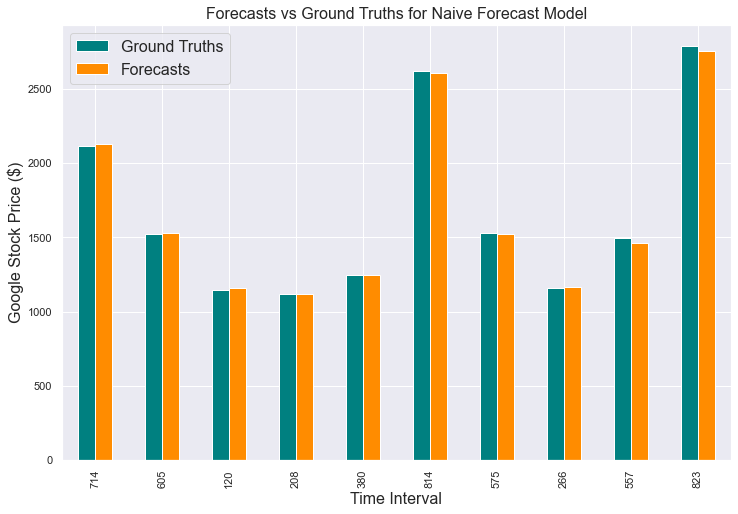

In [14]:
DATA_DICTIONARY = {'Ground Truths':y_valid[1:], 'Forecasts':model_1_predictions}
pd.DataFrame(data = DATA_DICTIONARY).sample(n = 10, random_state = 42).plot(kind = 'bar', color = ['teal', 'darkorange'])
plt.title(label = 'Forecasts vs Ground Truths for Naive Forecast Model', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

Let's evaluate the performance of the model using various evaluation metrics for a regression problem such as **R Squared, Adjusted R Squared, Mean Absolute Error(MAE), Mean Squared Error(MSE), Root Mean Squared Error (RMSE)** and **Mean Absolute Percentage Error (MAPE)**.

In [15]:
N, p = X.shape[0], 1
R_SQUARED = r2_score(y_true = y_valid[1:], y_pred = model_1_predictions)
ADJUSTED_R_SQUARED = 1 - ((1 - R_SQUARED) * (N - 1)) / (N - p - 1)
MAPE = mean_absolute_percentage_error(y_true = y_valid[1:], y_pred = model_1_predictions).numpy()
MAE = mean_absolute_error(y_true = y_valid[1:], y_pred = model_1_predictions).numpy()
MSE = mean_squared_error(y_true = y_valid[1:], y_pred = model_1_predictions).numpy()
RMSE = tf.math.sqrt(x = MSE).numpy()

COLUMNS = ['R_Squared', 'Adjusted_R_Squared', 'MAPE', 'MAE', 'RMSE', 'MSE']

model_1_df = pd.DataFrame(columns = COLUMNS, index = ['Naive Forecast Model'])
model_1_df['R_Squared'] = R_SQUARED
model_1_df['Adjusted_R_Squared'] = ADJUSTED_R_SQUARED
model_1_df['MAPE'] = MAPE
model_1_df['MAE'] = MAE
model_1_df['RMSE'] = RMSE
model_1_df['MSE'] = MSE

for column in model_1_df.columns:
    model_1_df[column] = model_1_df[column].apply(lambda x: round(number = x, ndigits = 2))
    
model_1_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE  \
Naive Forecast Model        1.0                 1.0  1.26  18.07  26.37   

                         MSE  
Naive Forecast Model  695.46

Let's define a function to create features and labels.

In [16]:
def create_features_labels(array, horizon = 1):
    """
    This is a function that will create features and labels.
    
    Args:
        array: Price in the form numpy array.
        horizon: The number of timestep to forecast into the future.
    
    Returns:
        Features and labels as a tuple.
    """
    features = array[:, :-horizon]
    labels = array[:, -horizon]
    return features, labels

Let's define a function to apply **sliding window** technique.

In [17]:
def slide_windows(array, horizon = 1, window_size = 7):
    """
    This is a function that will apply a sliding window technique.
    
    Args:
        array: Price in the form of numpy array.
        horizon: The number of timestep to forecast into the future.
        window_size: The number of timestep used to forecast a horizon.
        
    Returns:
        Features and labels as a tuple.
    """
    time_range = horizon + window_size
    windowed_steps = np.expand_dims(a = np.arange(time_range), axis = 0)
    windowed_index = windowed_steps + np.expand_dims(a = np.arange(len(array) - (time_range - 1)), axis = 0).T
    windowed_array = array[windowed_index]
    features, labels = create_features_labels(array = windowed_array, horizon = horizon)
    return features, labels

Let's call the function, create features and labels using sliding window technique. Then split them into train and validation sets.

In [18]:
features, labels = slide_windows(array = Y)
X_train, X_valid, y_train, y_valid = train_test_split(features, labels, test_size = 0.2, shuffle = False)
X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((3432, 7), (3432,), (859, 7), (859,))

Let's define a function that will create a list of callbacks to prevent potential overfitting.

In [19]:
def model_callbacks(model_path, monitoring_metric = 'val_loss', tolerance = 20, verbosity = 1):
    """
    This is a function that will create a list of callbacks, mainly an early stopping and a 
    model checkpoint callback to prevent a potential overfitting.
    
    Args:
        model_path: A path to a model instance.
        monitoring_metric: A metric to monitor during training.
        tolerance: A level of tolerance in case model does not improve.
        verbosity: A level of verbosity to display an output.
        
    Returns:
        A list of callbacks.
    """
    stop = EarlyStopping(monitor = monitoring_metric, patience = tolerance, restore_best_weights = True, verbose = verbosity)
    save = ModelCheckpoint(filepath = model_path, monitor = monitoring_metric, save_best_only = True, verbose = verbosity)
    callbacks = [stop, save]
    return callbacks

We have created a pipeline to load the data as efficient and fast as possible. Let's build a Feed Forward model with **Sequential API**.

In [20]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Feed Forward model with Sequential API
model_2 = Sequential(layers = [
                     Dense(units = 128, activation = 'relu'),
                     Dense(units = 128, activation = 'relu'),
                     Dense(units = 128, activation = 'relu'),
                     Dense(units = 1)
], name = 'Feed_Forward')

# Compiling the model
model_2.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])

# Fitting the model
model_training_2 = model_2.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32,
                               validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'{model_2.name}.h5'),
                               verbose = 1)

Epoch 1/500
108/108 [==============================] - 4s 16ms/step - loss: 6177.9370 - mae: 32.5362 - val_loss: 1719.0267 - val_mae: 30.2513

Epoch 00001: val_loss improved from inf to 1719.02673, saving model to Feed_Forward.h5
Epoch 2/500
108/108 [==============================] - 1s 10ms/step - loss: 153.1332 - mae: 8.1849 - val_loss: 1496.8878 - val_mae: 27.7605

Epoch 00002: val_loss improved from 1719.02673 to 1496.88782, saving model to Feed_Forward.h5
Epoch 3/500
108/108 [==============================] - 1s 10ms/step - loss: 159.2222 - mae: 8.5409 - val_loss: 2302.2402 - val_mae: 37.0313

Epoch 00003: val_loss did not improve from 1496.88782
Epoch 4/500
108/108 [==============================] - 1s 10ms/step - loss: 154.9618 - mae: 8.3346 - val_loss: 1380.4561 - val_mae: 26.6863

Epoch 00004: val_loss improved from 1496.88782 to 1380.45605, saving model to Feed_Forward.h5
Epoch 5/500
108/108 [==============================] - 1s 10ms/step - loss: 130.6988 - mae: 7.5532 - val_

In [21]:
# Displaying the summary of the model
model_2.summary()

Model: "Feed_Forward"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               1024      
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 129       
Total params: 34,177
Trainable params: 34,177
Non-trainable params: 0
_________________________________________________________________


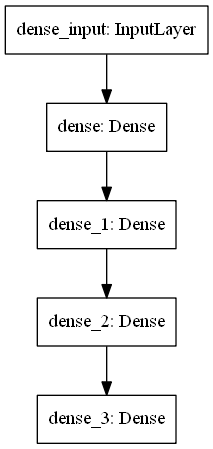

In [22]:
# Displaying the archiecture of the model
plot_model(model = model_2, to_file = f'{model_2.name}.png')

Let's define a function visualize the performance of the model per epoch.

In [23]:
def visualize_model_performance(history, model_name):
    """
    This is a function that will visualize the model performance per epoch.
    
    Args:
        history: A model training history object.
        model_name: A name of a model.
        
    Returns:
        A two-dimensional plots for MAE and Loss curves.
    """
    val_loss = history.history['val_loss']
    loss = history.history['loss']
    
    val_mae = history.history['val_mae']
    mae = history.history['mae']
    
    plt.plot(mae, label = 'Train MAE', c = 'teal')
    plt.plot(val_mae, label = 'Valid MAE', c = 'darkorange')
    plt.title(label = f'{model_name} Model MAE Curve', fontsize = 16)
    plt.xlabel(xlabel = 'Epochs', fontsize = 16)
    plt.ylabel(ylabel = 'MAE', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16)
    plt.show()
    
    print()
    
    plt.plot(loss, label = 'Train Loss', c = 'teal')
    plt.plot(val_loss, label = 'Valid Loss', c = 'darkorange')
    plt.title(label = f'{model_name} Model Loss Curve', fontsize = 16)
    plt.xlabel(xlabel = 'Epochs', fontsize = 16)
    plt.ylabel(ylabel = 'Loss', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16)
    plt.show()

Let's call the function and visualize the performance of the model per epoch.

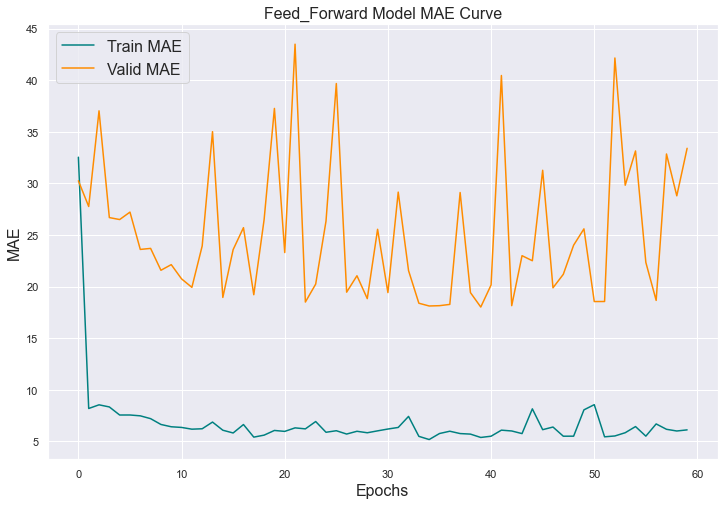

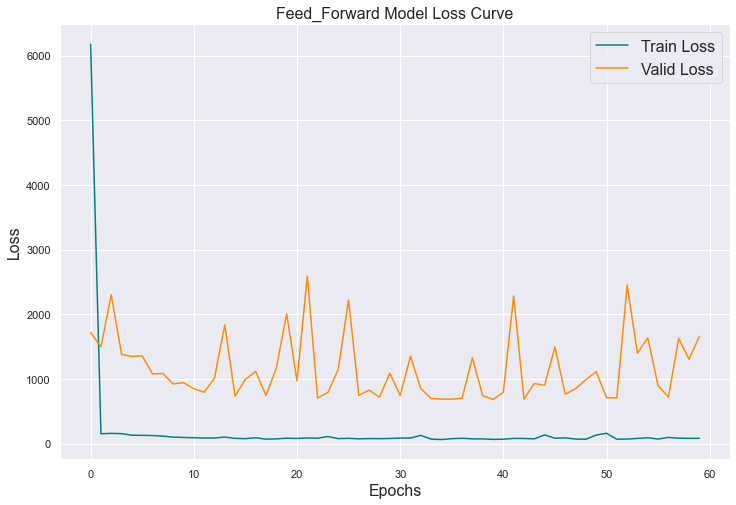

In [24]:
visualize_model_performance(history = model_training_2, model_name = model_2.name)

Let's define a function to plot time series performance for a particular model.

In [25]:
def plot_time_series(y_true, y_pred, window_size = 7, zoom = 0, model_name = None):
    """
    This is a function that will visualize a time series model performance.
    
    Args:
        y_true: Ground truth values.
        y_pred: Predicted values.
        zoom: A zoom level.
        model_name: A name of a model.
        
    Returns:
        A two-dimensional plot.
    """
    plt.plot(X[y_train.shape[0] + window_size:][zoom:], y_true[zoom:], label = 'Ground Truths', c = 'teal')
    plt.plot(X[y_train.shape[0] + window_size:][zoom:], y_pred[zoom:], label = 'Forecasts', c = 'darkorange')
    plt.title(label = f'{model_name} Model Performance', fontsize = 16)
    plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
    plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16)
    plt.show()

Let's load the best model, make predictions on validation set and call the function.

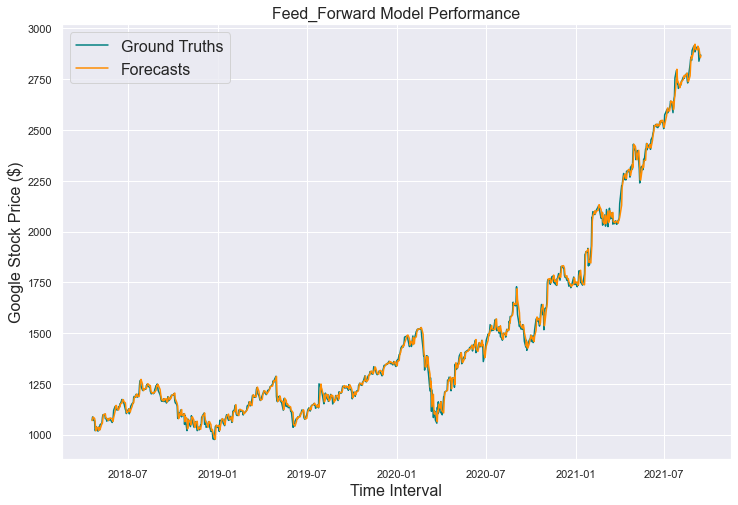

In [26]:
model_2 = load_model(filepath = f'{model_2.name}.h5')
model_2_predictions = tf.squeeze(input = model_2.predict(x = X_valid)).numpy()
plot_time_series(y_true = y_valid, y_pred = model_2_predictions, model_name = model_2.name)

Let's zoom in.

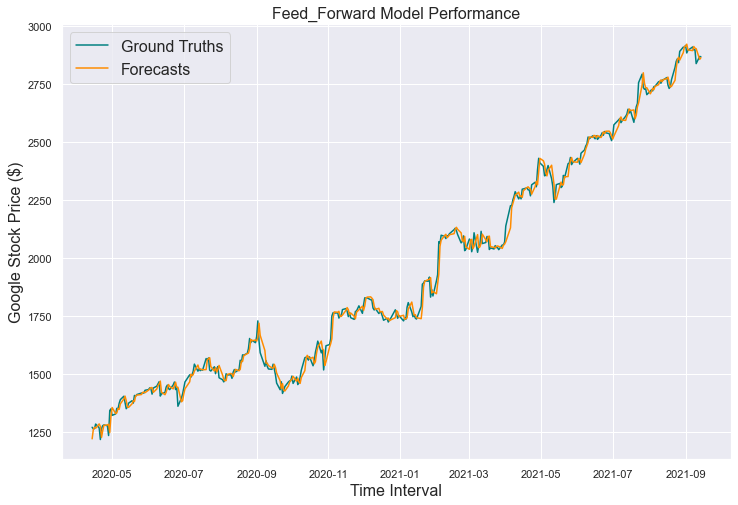

In [27]:
plot_time_series(y_true = y_valid, y_pred = model_2_predictions, zoom = 500, model_name = model_2.name)

Let's define a function to visually compare the forecasted values to ground truth values.

In [28]:
def visually_compare(y_true, y_pred, model_name = None):
    """
    This is a function that will visually compare the forecasted values to ground truth values.
    
    Args:
        y_true: Ground truth values.
        y_pred: Forecasted values.
        model_name: A name of a model.
        
    Returns:
        A two-dimensional plot.
    """
    data_dictionary = {'Ground Truths':y_true, 'Forecasts':y_pred}
    pd.DataFrame(data = data_dictionary).sample(n = 10, random_state = 42).plot(kind = 'bar', color = ['teal', 'darkorange'])
    plt.title(label = f'Forecasts vs Ground Truths for {model_name} Model', fontsize = 16)
    plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
    plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
    plt.legend(loc = 'best', fontsize = 16)
    plt.show()

Let's call the function and visually compare the forecasted values to ground truth values.

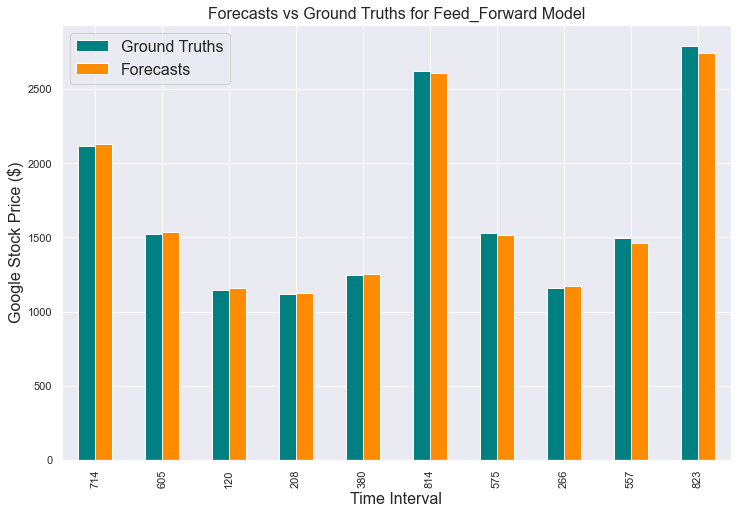

In [29]:
visually_compare(y_true = y_valid, y_pred = model_2_predictions, model_name = model_2.name)

Let's define a function to evaluate the performance of a particular model using various evaluation metrics such as **R Squared, Adjusted R Squared, Mean Absolute Error(MAE), Mean Squared Error(MSE), Root Mean Squared Error (RMSE)** and **Mean Absolute Percentage Error (MAPE)**

In [30]:
def evaluate_model_performance(y_true, y_pred, model_name = None):
    """
    This is a function that will evaluate the performance of a particular model using 
    various evaluation metrics for a regression proble such as R Squared, Adjusted R Squared, 
    Mean Absolute Error(MAE), Mean Squared Error(MSE), Root Mean Squared Error (RMSE) and 
    Mean Absolute Percentage Error (MAPE).
    
    Args:
        y_true: Ground truth values.
        y_pred: Forecasted values.
        model_name: A name of a model.
        
    Returns:
        A pandas dataframe.
    """
    N, p = features.shape[0], features.shape[1]
    R2_SQUARED = r2_score(y_true = y_true, y_pred = y_pred)
    ADJUSTED_R_SQUARED = 1 - (((1 - R2_SQUARED) * (N - 1)) / (N - p - 1))
    MAPE = mean_absolute_percentage_error(y_true = y_true, y_pred = y_pred).numpy()
    MAE = mean_absolute_error(y_true = y_true, y_pred = y_pred).numpy()
    MSE = mean_squared_error(y_true = y_true, y_pred = y_pred).numpy()
    RMSE = tf.math.sqrt(x = MSE).numpy()
    
    df = pd.DataFrame(columns = COLUMNS, index = [model_name + ' Model'])
    df['R_Squared'] = R2_SQUARED
    df['Adjusted_R_Squared'] = ADJUSTED_R_SQUARED
    df['MAPE'] = MAPE
    df['MAE'] = MAE
    df['MSE'] = MSE
    df['RMSE'] = RMSE
    
    for column in df.columns:
        df[column]  = df[column].apply(lambda x: round(number = x, ndigits = 2))
        
    return df

Let's call the function and evaluate the performance of the model.

In [31]:
model_2_df = evaluate_model_performance(y_true = y_valid, y_pred = model_2_predictions, model_name = model_2.name)
model_2_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE    MSE
Feed_Forward Model        1.0                 1.0  1.25  18.02  26.14  683.5

Let's build an LSTM model with **Sequential API**.

In [32]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating an LSTM model with Sequential API
model_3 = Sequential(layers = [
                     Lambda(function = lambda x: tf.expand_dims(input = x, axis = 1)),
                     LSTM(units = 128, activation = 'relu'),
                     Dense(units = 1)
], name = 'LSTM')

# Compiling the model
model_3.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])

# Fitting the model
model_training_3 = model_3.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32, 
                               validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'{model_3.name}.h5'),
                               verbose = 1)

Epoch 1/500
108/108 [==============================] - 8s 25ms/step - loss: 25051.8047 - mae: 73.6298 - val_loss: 1446.7258 - val_mae: 27.3408

Epoch 00001: val_loss improved from inf to 1446.72583, saving model to LSTM.h5
Epoch 2/500
108/108 [==============================] - 2s 17ms/step - loss: 145.3150 - mae: 7.9740 - val_loss: 1466.3226 - val_mae: 27.6396

Epoch 00002: val_loss did not improve from 1446.72583
Epoch 3/500
108/108 [==============================] - 2s 16ms/step - loss: 141.0767 - mae: 7.8001 - val_loss: 1484.4464 - val_mae: 27.9220

Epoch 00003: val_loss did not improve from 1446.72583
Epoch 4/500
108/108 [==============================] - 2s 19ms/step - loss: 136.8058 - mae: 7.7229 - val_loss: 1395.1077 - val_mae: 26.7734

Epoch 00004: val_loss improved from 1446.72583 to 1395.10767, saving model to LSTM.h5
Epoch 5/500
108/108 [==============================] - 2s 20ms/step - loss: 138.3760 - mae: 7.7310 - val_loss: 1395.6787 - val_mae: 26.8685

Epoch 00005: val_lo

In [33]:
# Displaying the summary of the model
model_3.summary()

Model: "LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1, 7)              0         
_________________________________________________________________
lstm (LSTM)                  (None, 128)               69632     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 129       
Total params: 69,761
Trainable params: 69,761
Non-trainable params: 0
_________________________________________________________________


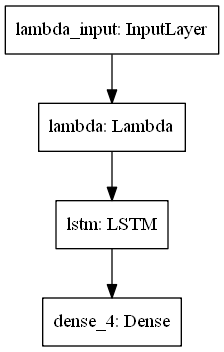

In [34]:
# Displaying the architecture of the model
plot_model(model = model_3, to_file = f'{model_3.name}.png')

Let's call the function and visualize the performance of the model per epoch.

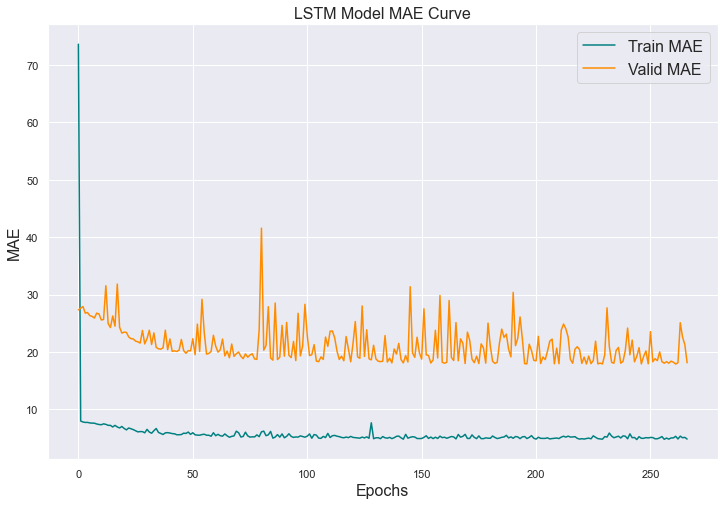

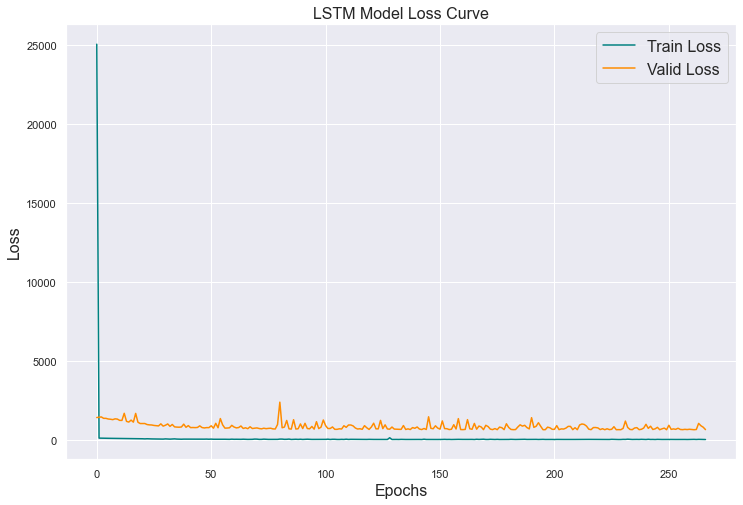

In [35]:
visualize_model_performance(history = model_training_3, model_name = model_3.name)

Let's load the best model, make predictions on validation set and plot time series.

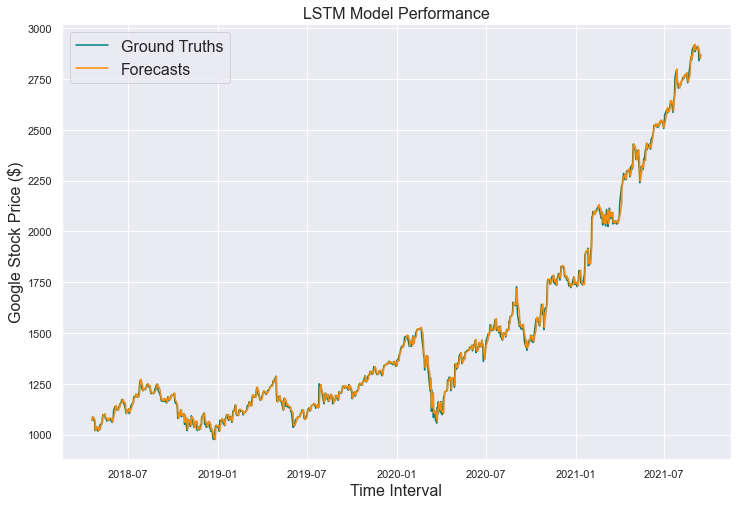

In [36]:
model_3 = load_model(filepath = f'{model_3.name}.h5')
model_3_predictions = tf.squeeze(input = model_3.predict(x = X_valid)).numpy()
plot_time_series(y_true = y_valid, y_pred = model_3_predictions, model_name = model_3.name)

Let's zoom in.

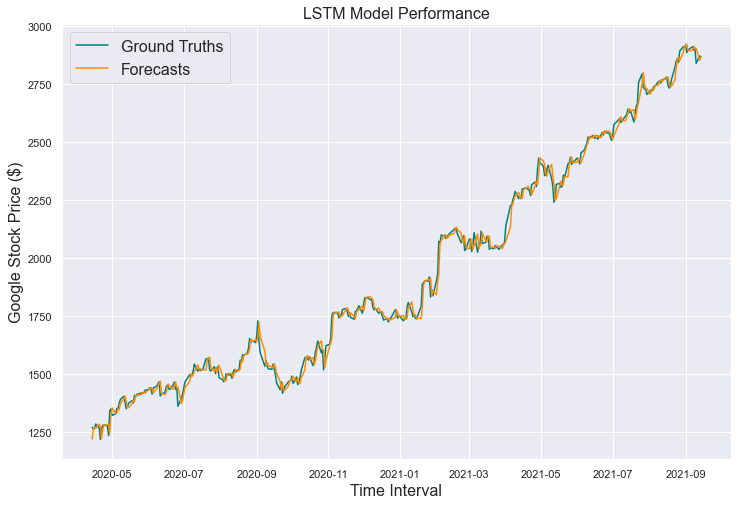

In [37]:
plot_time_series(y_true = y_valid, y_pred = model_3_predictions, zoom = 500, model_name = model_3.name)

Let's visually compare the forecasted values to ground truth values.

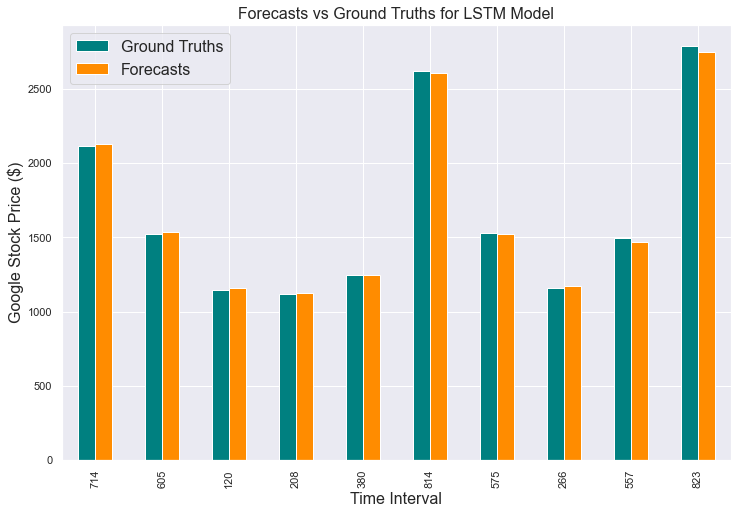

In [38]:
visually_compare(y_true = y_valid, y_pred = model_3_predictions, model_name = model_3.name)

Let's call the function and evaluate the performance of the model.

In [39]:
model_3_df = evaluate_model_performance(y_true = y_valid, y_pred = model_3_predictions, model_name = model_3.name)
model_3_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE     MSE
LSTM Model        1.0                 1.0  1.25  17.92  26.02  677.24

Let's build a Bidirectional LSTM model with **Functional API**.

In [40]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Bidirectional LSTM model with Functional API
input_layer = Input(shape = (features.shape[1],), name = 'Input_Layer')
x = Lambda(function = lambda x: tf.expand_dims(input = x, axis = 1))(input_layer)
x = Bidirectional(layer = LSTM(units = 128, activation = 'relu'))(x)
output_layer = Dense(units = 1, name = 'Output_Layer')(x)
model_4 = Model(inputs = input_layer, outputs = output_layer, name = 'Bidirectional_LSTM')

# Compiling the model
model_4.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])

# Fitting the model
model_training_4 = model_4.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32,
                               validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'{model_4.name}.h5'),
                               verbose = 1)

Epoch 1/500
108/108 [==============================] - 15s 40ms/step - loss: 15482.6973 - mae: 50.2513 - val_loss: 1574.4938 - val_mae: 28.6219

Epoch 00001: val_loss improved from inf to 1574.49377, saving model to Bidirectional_LSTM.h5
Epoch 2/500
108/108 [==============================] - 3s 24ms/step - loss: 162.9410 - mae: 8.4984 - val_loss: 1527.6318 - val_mae: 28.0848

Epoch 00002: val_loss improved from 1574.49377 to 1527.63184, saving model to Bidirectional_LSTM.h5
Epoch 3/500
108/108 [==============================] - 3s 25ms/step - loss: 158.8863 - mae: 8.3486 - val_loss: 1711.5177 - val_mae: 30.43450s - loss: 152.2905 - mae: 8.30 - ETA: 0s - loss: 160.3085 - 

Epoch 00003: val_loss did not improve from 1527.63184
Epoch 4/500
108/108 [==============================] - 3s 24ms/step - loss: 145.4118 - mae: 7.9456 - val_loss: 1445.8756 - val_mae: 27.3213

Epoch 00004: val_loss improved from 1527.63184 to 1445.87561, saving model to Bidirectional_LSTM.h5
Epoch 5/500
108/108 [===

In [41]:
# Displaying the summary of the model
model_4.summary()

Model: "Bidirectional_LSTM"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
lambda_1 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
bidirectional (Bidirectional (None, 256)               139264    
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 257       
Total params: 139,521
Trainable params: 139,521
Non-trainable params: 0
_________________________________________________________________


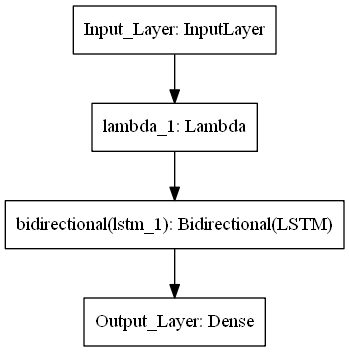

In [42]:
# Displaying the architecture of the model
plot_model(model = model_4, to_file = f'{model_4.name}.png')

Let's call the function and visualize the performance of the model per epoch.

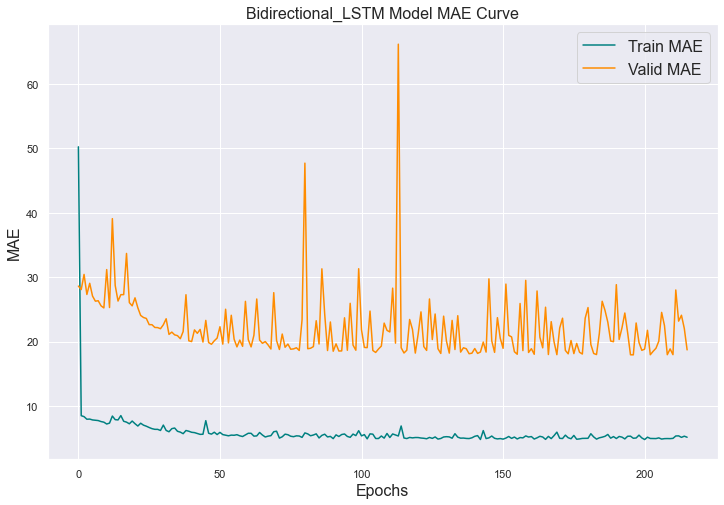

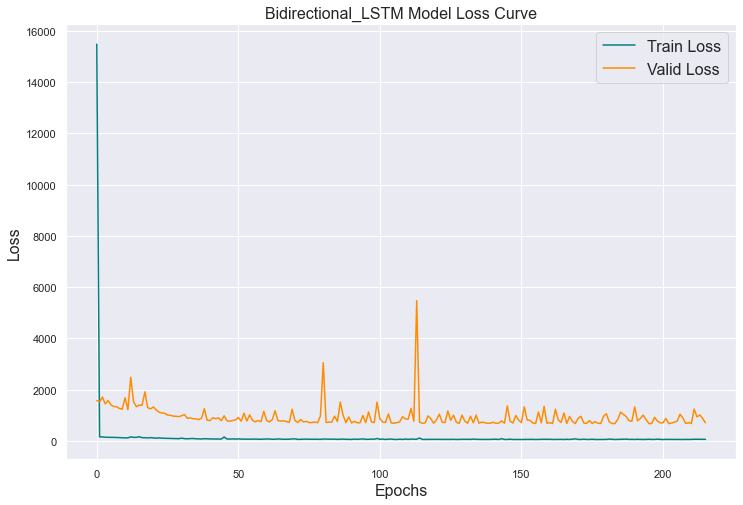

In [43]:
visualize_model_performance(history = model_training_4, model_name = model_4.name)

Let's load the best model, make predictions on validation set and plot time series.

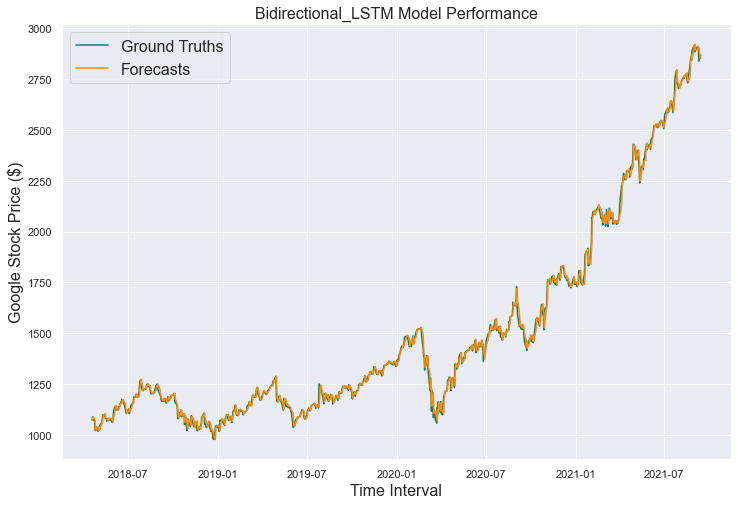

In [44]:
model_4 = load_model(filepath = f'{model_4.name}.h5')
model_4_predictions = tf.squeeze(input = model_4.predict(x = X_valid)).numpy()
plot_time_series(y_true = y_valid, y_pred = model_4_predictions, model_name = model_4.name)

Let's zoom in.

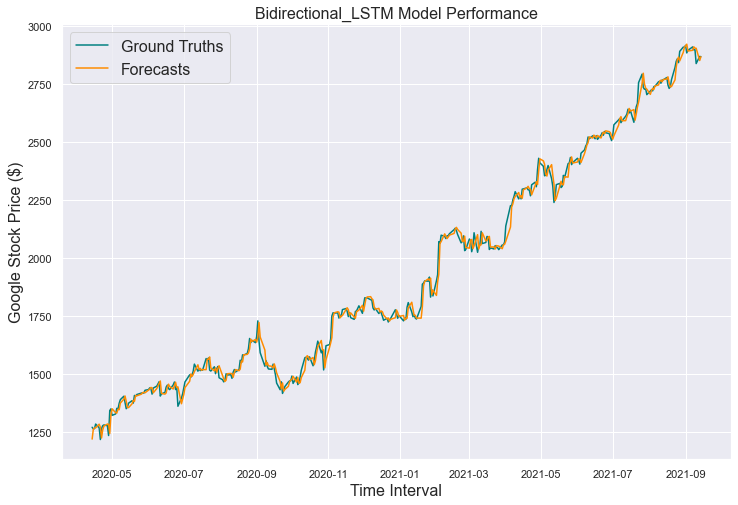

In [45]:
plot_time_series(y_true = y_valid, y_pred = model_4_predictions, zoom = 500, model_name = model_4.name)

Let's visually compare the forecasted values to ground truth values.

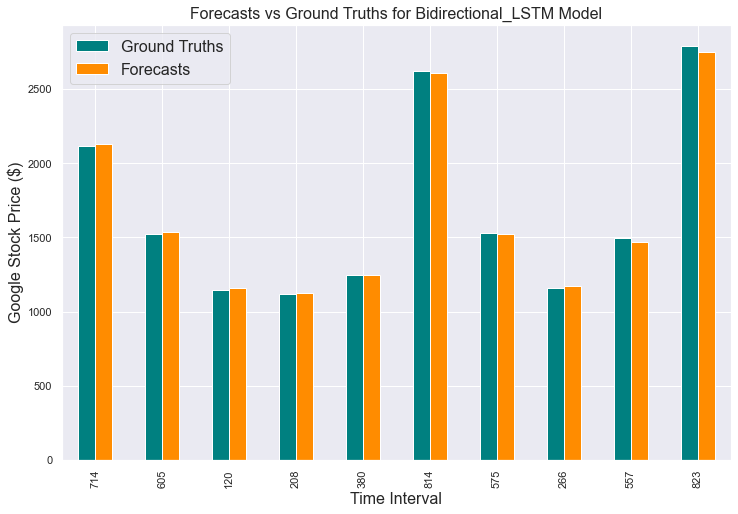

In [46]:
visually_compare(y_true = y_valid, y_pred = model_4_predictions, model_name = model_4.name)

Let's call the function and evaluate the performance of the model.

In [47]:
model_4_df = evaluate_model_performance(y_true = y_valid, y_pred = model_4_predictions, model_name = model_4.name)
model_4_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE  \
Bidirectional_LSTM Model        1.0                 1.0  1.25  17.95  26.03   

                             MSE  
Bidirectional_LSTM Model  677.56

Let's build a GRU model with **Sequential API**.

In [48]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a GRU model with Sequential API
model_5 = Sequential(layers = [
                     Lambda(function = lambda x: tf.expand_dims(input = x, axis = 1)),
                     GRU(units = 128, activation = 'relu'),
                     Dense(units = 1)
], name = 'GRU')

# Compiling the model
model_5.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])

# Fitting the model
model_training_5 = model_5.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32,
                               validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'{model_5.name}.h5'),
                               verbose = 1)

Epoch 1/500
108/108 [==============================] - 10s 28ms/step - loss: 10767.2627 - mae: 43.5660 - val_loss: 1477.9114 - val_mae: 27.5475

Epoch 00001: val_loss improved from inf to 1477.91138, saving model to GRU.h5
Epoch 2/500
108/108 [==============================] - 2s 14ms/step - loss: 137.3725 - mae: 7.7582 - val_loss: 1630.5134 - val_mae: 29.5018

Epoch 00002: val_loss did not improve from 1477.91138
Epoch 3/500
108/108 [==============================] - 2s 16ms/step - loss: 138.1667 - mae: 7.7269 - val_loss: 1351.3264 - val_mae: 27.2512

Epoch 00003: val_loss improved from 1477.91138 to 1351.32642, saving model to GRU.h5
Epoch 4/500
108/108 [==============================] - 2s 17ms/step - loss: 104.2789 - mae: 6.7465 - val_loss: 1543.2997 - val_mae: 28.4639

Epoch 00004: val_loss did not improve from 1351.32642
Epoch 5/500
108/108 [==============================] - 2s 16ms/step - loss: 122.9486 - mae: 7.3392 - val_loss: 1466.7023 - val_mae: 27.5414

Epoch 00005: val_los

In [49]:
# Displaying the summary of the model
model_5.summary()

Model: "GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
gru (GRU)                    (None, 128)               52608     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 129       
Total params: 52,737
Trainable params: 52,737
Non-trainable params: 0
_________________________________________________________________


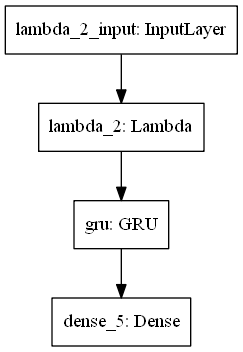

In [50]:
# Displaying the architecture of the model
plot_model(model = model_5, to_file = f'{model_5.name}.png')

Let's call the function and visualize the performance of the model per epoch.

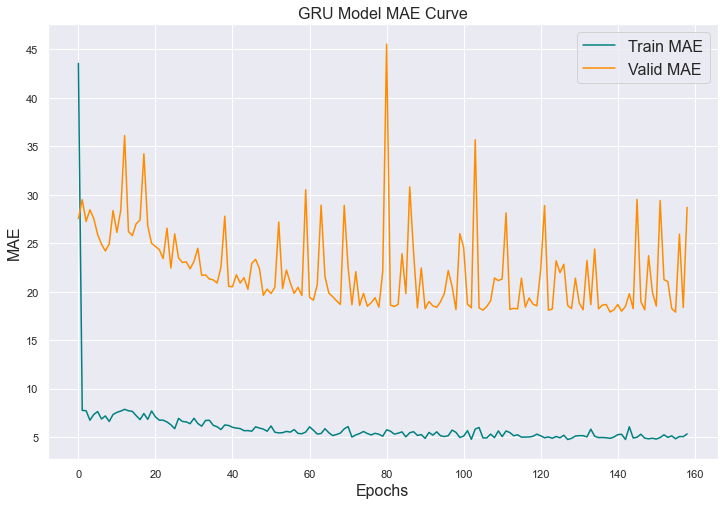

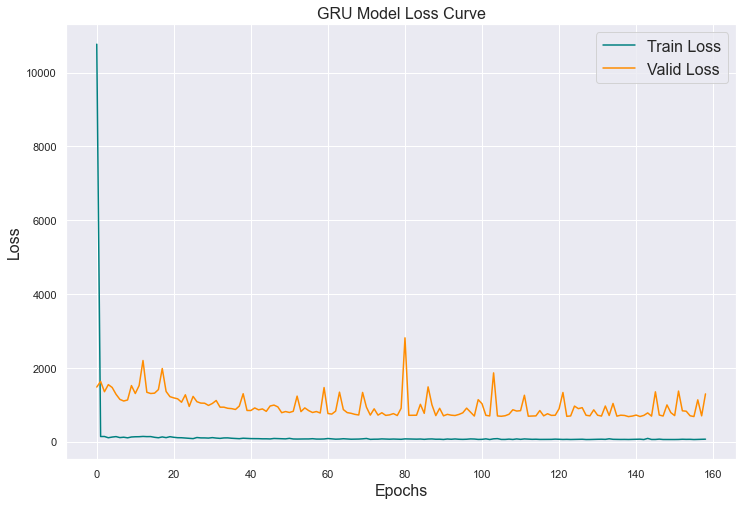

In [51]:
visualize_model_performance(history = model_training_5, model_name = model_5.name)

Let's load the best model, make predictions on validation set and plot time series.

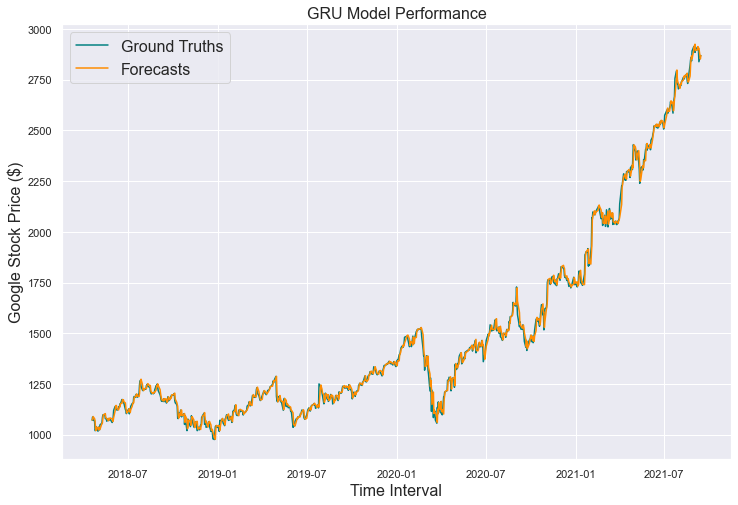

In [52]:
model_5 = load_model(filepath = f'{model_5.name}.h5')
model_5_predictions = tf.squeeze(input = model_5.predict(x = X_valid)).numpy()
plot_time_series(y_true = y_valid, y_pred = model_5_predictions, model_name = model_5.name)

Let's zoom in.

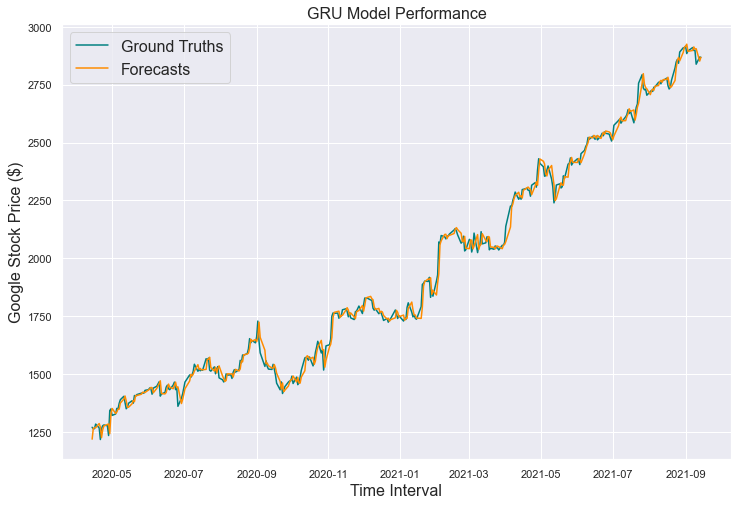

In [53]:
plot_time_series(y_true = y_valid, y_pred = model_5_predictions, zoom = 500, model_name = model_5.name)

Let's visually compare the forecasted values to ground truth values.

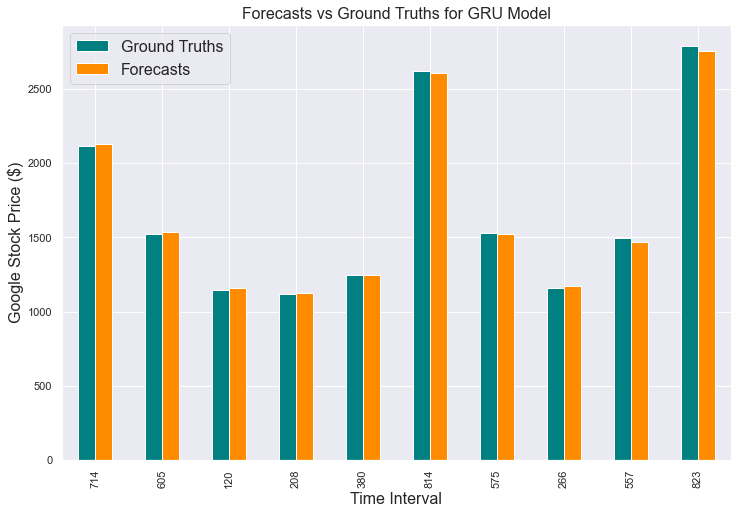

In [54]:
visually_compare(y_true = y_valid, y_pred = model_5_predictions, model_name = model_5.name)

Let's call the function and evaluate the performance of the model.

In [55]:
model_5_df = evaluate_model_performance(y_true = y_valid, y_pred = model_5_predictions, model_name = model_5.name)
model_5_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE    MSE
GRU Model        1.0                 1.0  1.25  17.91  26.02  677.3

Let's build a Bidirectional GRU model with **Functional API**.

In [56]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Bidirectional GRU model with Funtional API
input_layer = Input(shape = (features.shape[1],), name = 'Input_Layer')
x = Lambda(function = lambda x: tf.expand_dims(input = x, axis = 1))(input_layer)
x = Bidirectional(layer = GRU(units = 128, activation = 'relu'))(x)
output_layer = Dense(units = 1, name = 'Output_Layer')(x)
model_6 = Model(inputs = input_layer, outputs = output_layer, name = 'Bidirectional_GRU')

# Compiling the model
model_6.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])

# Fitting the model
model_training_6 = model_6.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32,
                               validation_data = (X_valid, y_valid),
                               callbacks = model_callbacks(model_path = f'{model_6.name}.h5'),
                               verbose = 1)

Epoch 1/500
108/108 [==============================] - 15s 35ms/step - loss: 23768.7324 - mae: 62.6401 - val_loss: 1592.4744 - val_mae: 28.7321

Epoch 00001: val_loss improved from inf to 1592.47437, saving model to Bidirectional_GRU.h5
Epoch 2/500
108/108 [==============================] - 2s 22ms/step - loss: 153.5037 - mae: 8.1878 - val_loss: 1654.2551 - val_mae: 29.5507

Epoch 00002: val_loss did not improve from 1592.47437
Epoch 3/500
108/108 [==============================] - 2s 21ms/step - loss: 158.9149 - mae: 8.2889 - val_loss: 1651.5448 - val_mae: 29.5174

Epoch 00003: val_loss did not improve from 1592.47437
Epoch 4/500
108/108 [==============================] - 2s 22ms/step - loss: 149.5840 - mae: 8.0554 - val_loss: 1542.3927 - val_mae: 28.1794

Epoch 00004: val_loss improved from 1592.47437 to 1542.39270, saving model to Bidirectional_GRU.h5
Epoch 5/500
108/108 [==============================] - 2s 21ms/step - loss: 149.8187 - mae: 8.0754 - val_loss: 1502.2672 - val_mae: 2

In [57]:
# Displaying the summary of the model
model_6.summary()

Model: "Bidirectional_GRU"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Input_Layer (InputLayer)     [(None, 7)]               0         
_________________________________________________________________
lambda_3 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
bidirectional_1 (Bidirection (None, 256)               105216    
_________________________________________________________________
Output_Layer (Dense)         (None, 1)                 257       
Total params: 105,473
Trainable params: 105,473
Non-trainable params: 0
_________________________________________________________________


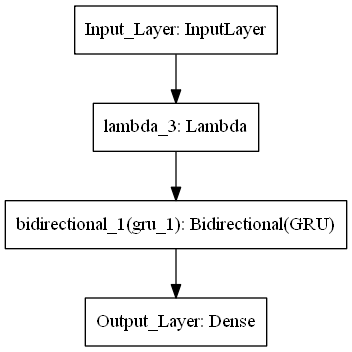

In [58]:
# Displaying the architecture of the model
plot_model(model = model_6, to_file = f'{model_6.name}.png')

Let's call the function and visualize the performance of the model per epoch.

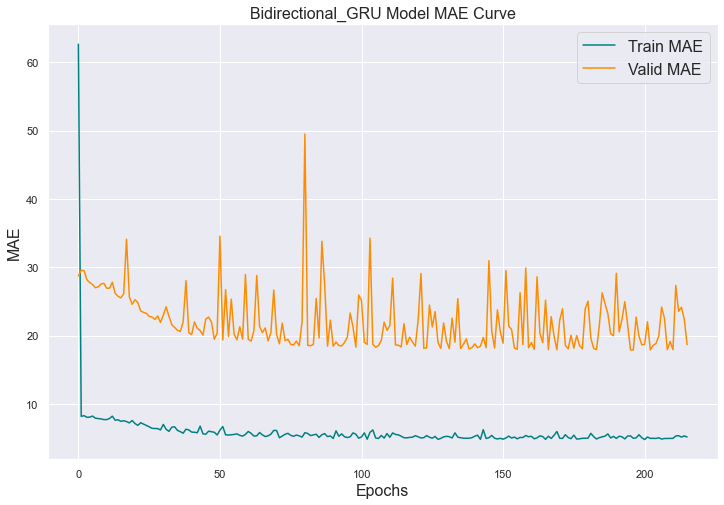

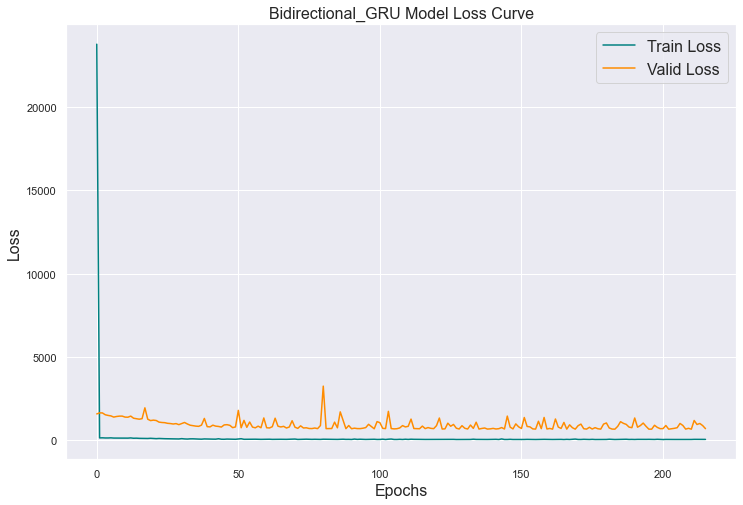

In [59]:
visualize_model_performance(history = model_training_6, model_name = model_6.name)

Let's load the best model, make predictions on validation set and plot time series.

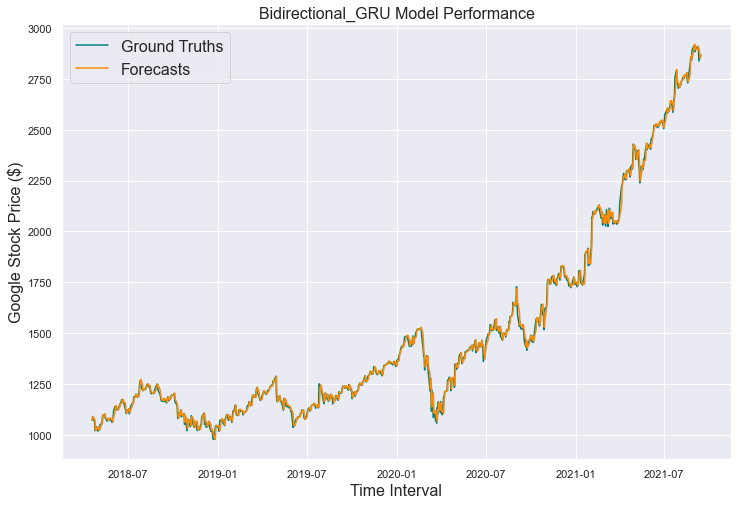

In [60]:
model_6 = load_model(filepath = f'{model_6.name}.h5')
model_6_predictions = tf.squeeze(input = model_6.predict(x = X_valid)).numpy()
plot_time_series(y_true = y_valid, y_pred = model_6_predictions, model_name = model_6.name)

Let's zoom in.

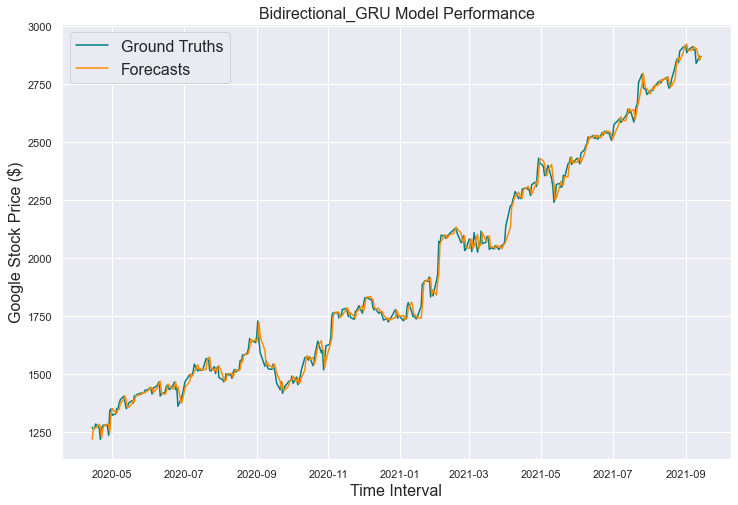

In [61]:
plot_time_series(y_true = y_valid, y_pred = model_6_predictions, zoom = 500, model_name = model_6.name)

Let's visually compare the forecasted values to ground truth values.

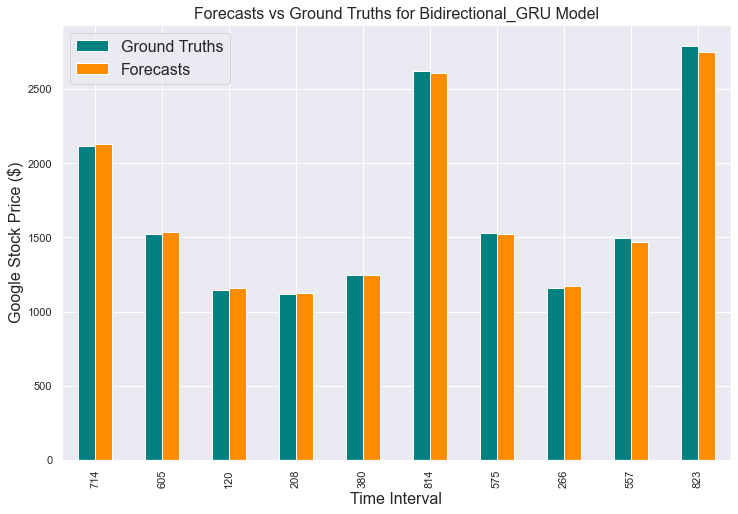

In [62]:
visually_compare(y_true = y_valid, y_pred = model_6_predictions, model_name = model_6.name)

Let's call the function and evaluate the performance of the model.

In [63]:
model_6_df = evaluate_model_performance(y_true = y_valid, y_pred = model_6_predictions, model_name = model_6.name)
model_6_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE  \
Bidirectional_GRU Model        1.0                 1.0  1.25  17.92  26.04   

                            MSE  
Bidirectional_GRU Model  677.92

Let's build a Conv1D model with **Sequential API**.

In [64]:
# Setting a global seed to maintain reproducibility
tf.random.set_seed(seed = 42)

# Creating a Conv1D model with Sequential API
model_7 = Sequential(layers = [
                     Lambda(function = lambda x: tf.expand_dims(input = x, axis = 1)),
                     Conv1D(filters = 128, kernel_size = 7, padding = 'causal', activation = 'relu'),
                     MaxPool1D(padding = 'same'),
                     Dense(1)
], name = 'Conv1D')

# Compiling the model
model_7.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])

# Fitting the model
model_training_7 = model_7.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32,
                               validation_data = (X_valid, y_valid), 
                               callbacks = model_callbacks(model_path = f'{model_7.name}.h5'),
                               verbose = 1)

Epoch 1/500
108/108 [==============================] - 4s 14ms/step - loss: 13002.5537 - mae: 49.3008 - val_loss: 1760.6825 - val_mae: 30.1515

Epoch 00001: val_loss improved from inf to 1760.68250, saving model to Conv1D.h5
Epoch 2/500
108/108 [==============================] - 1s 7ms/step - loss: 175.7821 - mae: 8.7859 - val_loss: 1866.5529 - val_mae: 31.3349

Epoch 00002: val_loss did not improve from 1760.68250
Epoch 3/500
108/108 [==============================] - 1s 9ms/step - loss: 176.5422 - mae: 8.7653 - val_loss: 1816.3549 - val_mae: 30.8259

Epoch 00003: val_loss did not improve from 1760.68250
Epoch 4/500
108/108 [==============================] - 1s 9ms/step - loss: 171.7457 - mae: 8.6891 - val_loss: 1730.1198 - val_mae: 29.9051

Epoch 00004: val_loss improved from 1760.68250 to 1730.11975, saving model to Conv1D.h5
Epoch 5/500
108/108 [==============================] - 1s 8ms/step - loss: 174.7924 - mae: 8.7210 - val_loss: 1715.6812 - val_mae: 29.7874

Epoch 00005: val_lo

In [65]:
# Displaying the summary of the model
model_7.summary()

Model: "Conv1D"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_4 (Lambda)            (None, 1, 7)              0         
_________________________________________________________________
conv1d (Conv1D)              (None, 1, 128)            6400      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 128)            0         
_________________________________________________________________
dense_6 (Dense)              (None, 1, 1)              129       
Total params: 6,529
Trainable params: 6,529
Non-trainable params: 0
_________________________________________________________________


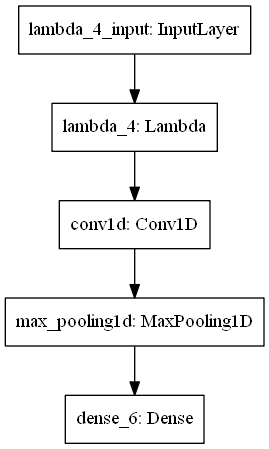

In [66]:
# Displaying the architecture of the model
plot_model(model = model_7, to_file = f'{model_7.name}.png')

Let's call the function and visualize the performance of the model per epoch.

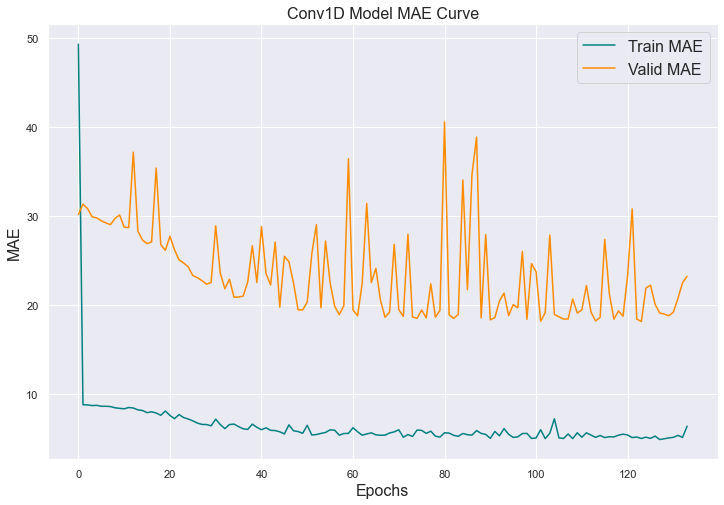

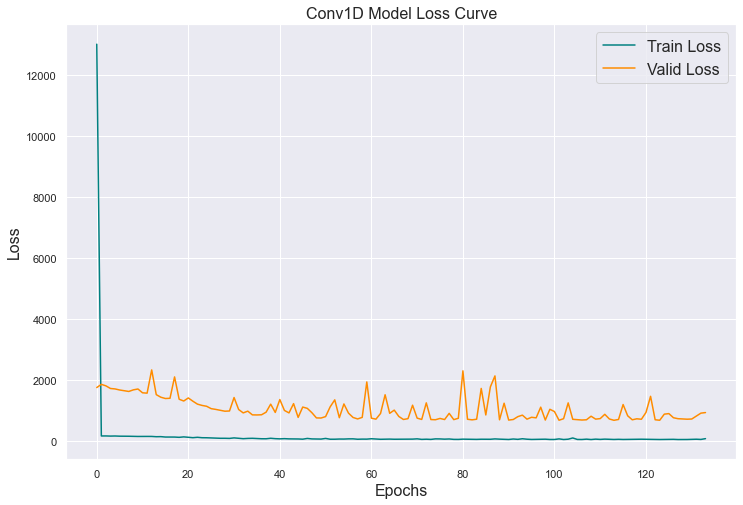

In [67]:
visualize_model_performance(history = model_training_7, model_name = model_7.name)

Let's load the best model, make predictions on validation set and plot time series.

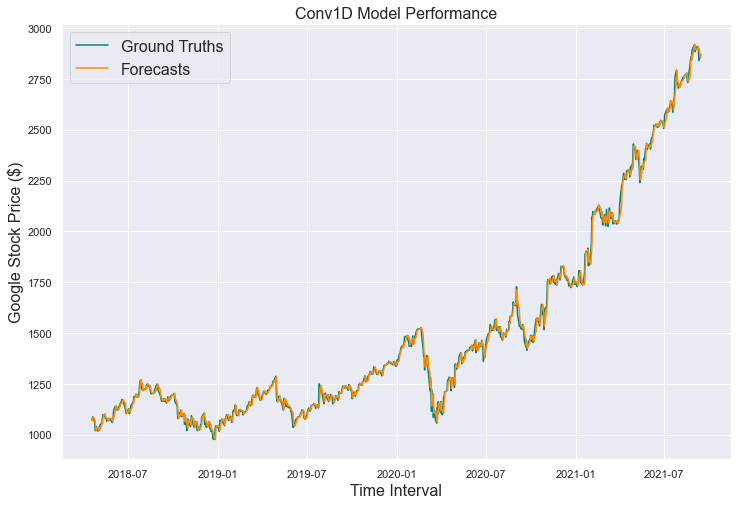

In [68]:
model_7 = load_model(filepath = f'{model_7.name}.h5')
model_7_predictions = tf.squeeze(input = model_7.predict(x = X_valid)).numpy()
plot_time_series(y_true = y_valid, y_pred = model_7_predictions, model_name = model_7.name)

Let's zoom in.

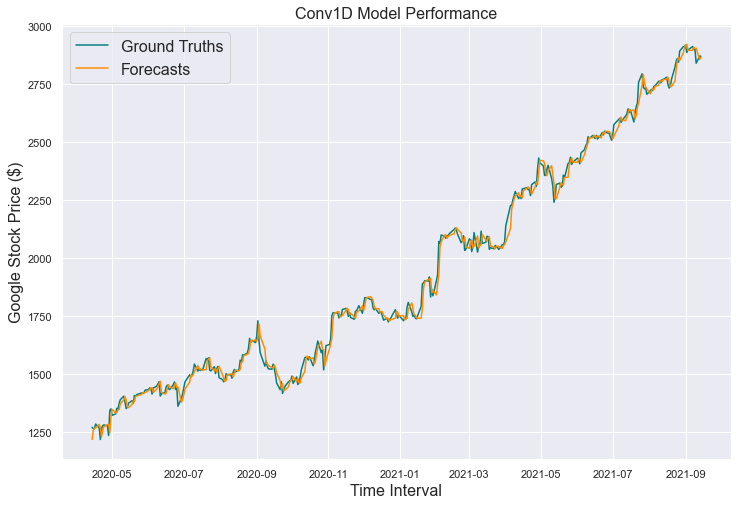

In [69]:
plot_time_series(y_true = y_valid, y_pred = model_7_predictions, zoom = 500, model_name = model_7.name)

Let's visually compare the forecasted values to ground truth values.

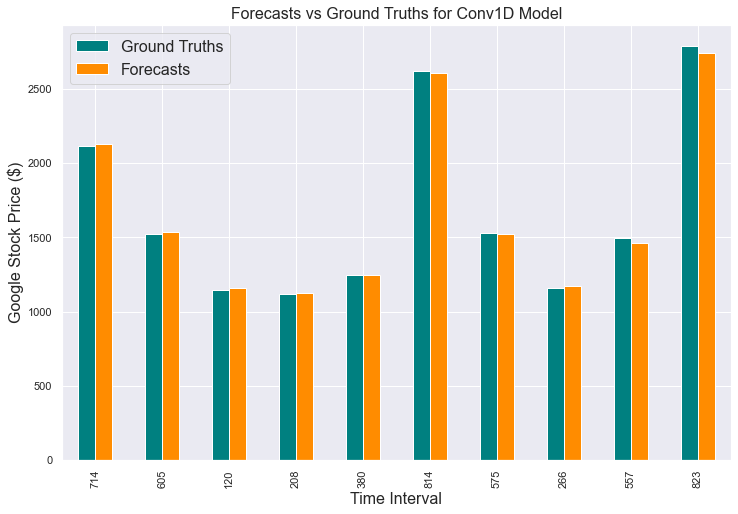

In [70]:
visually_compare(y_true = y_valid, y_pred = model_7_predictions, model_name = model_7.name)

Let's call the function and evaluate the performance of the model.

In [71]:
model_7_df = evaluate_model_performance(y_true = y_valid, y_pred = model_7_predictions, model_name = model_7.name)
model_7_df

R_Squared  Adjusted_R_Squared  MAPE   MAE   RMSE     MSE
Conv1D Model        1.0                 1.0  1.27  18.2  26.25  689.11

Let's define a function to create a list of models that form an **Ensemble** model.

In [72]:
def create_ensemble_model(num_models = 10):
    """
    This is a function that will create a list of models which form
    an ensemble model.
    
    Args:
        num_models: The number of models to build.
    
    Returns:
        A list of models.
    """
    models = []
    
    for x in range(1, num_models + 1):
        model = clone_model(model = model_5)
        model.compile(optimizer = Adam(), loss = mse, metrics = ['mae'])
        model_training = model.fit(x = X_train, y = y_train, epochs = 500, batch_size = 32,
                                   validation_data = (X_valid, y_valid),
                                   callbacks = model_callbacks(model_path = f'Model_{x}.h5', verbosity = 0),
                                   verbose = 0)
        models.append(model)
        
    return models

Let's call the function, create a list of models and display the number of models that will form the ensemble model.

In [73]:
ensemble_model = create_ensemble_model()
print(f'The number of models: {len(ensemble_model)}')

The number of models: 10


Let's load each model, make predictions on validation set, aggregate the forecasts and plot time series with **95%** confidence interval.

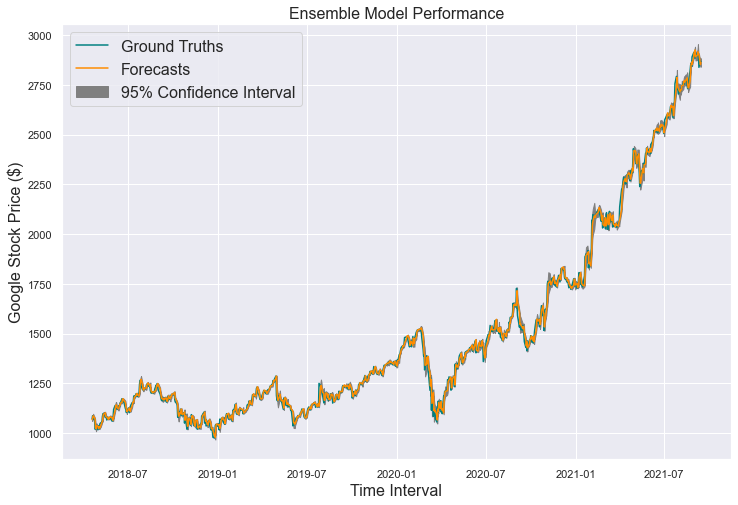

In [74]:
forecasts = []
model_paths = [model for model in os.listdir() if model.startswith('Model_')]

for model_path in model_paths:
    model = load_model(filepath = model_path)
    model_prediction = tf.squeeze(input = model.predict(x = X_valid)).numpy()
    forecasts.append(model_prediction)
    
aggregated_model_forecast = tf.math.reduce_mean(input_tensor = forecasts, axis = 0).numpy()
aggregated_stds = tf.math.reduce_std(input_tensor = forecasts, axis = 0).numpy() * 1.96
upper_bound = aggregated_model_forecast + aggregated_stds
lower_bound = aggregated_model_forecast - aggregated_stds

plt.plot(X[y_train.shape[0] + 7:], y_valid, label = 'Ground Truths', c = 'teal')
plt.plot(X[y_train.shape[0] + 7:], aggregated_model_forecast, label = 'Forecasts', c = 'darkorange')
plt.fill_between(x = X[y_train.shape[0] + 7:], y1 = upper_bound, y2 = lower_bound, label = '95% Confidence Interval', color = 'grey')
plt.title(label = 'Ensemble Model Performance', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

Let's zoom in.

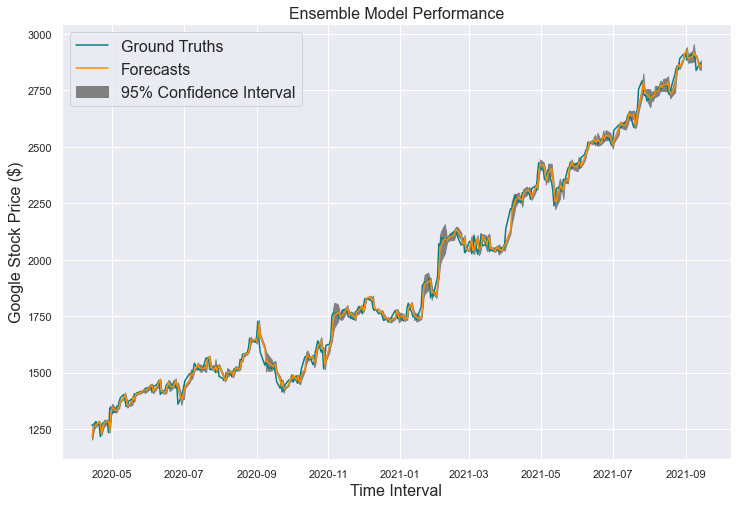

In [75]:
plt.plot(X[y_train.shape[0] + 7:][500:], y_valid[500:], label = 'Ground Truths', c = 'teal')
plt.plot(X[y_train.shape[0] + 7:][500:], aggregated_model_forecast[500:], label = 'Forecasts', c = 'darkorange')
plt.fill_between(x = X[y_train.shape[0] + 7:][500:], y1 = upper_bound[500:], y2 = lower_bound[500:], label = '95% Confidence Interval', color = 'grey')
plt.title(label = 'Ensemble Model Performance', fontsize = 16)
plt.ylabel(ylabel = 'Google Stock Price ($)', fontsize = 16)
plt.xlabel(xlabel = 'Time Interval', fontsize = 16)
plt.legend(loc = 'best', fontsize = 16)
plt.show()

Let's visually compare the forecasted values to ground truth values.

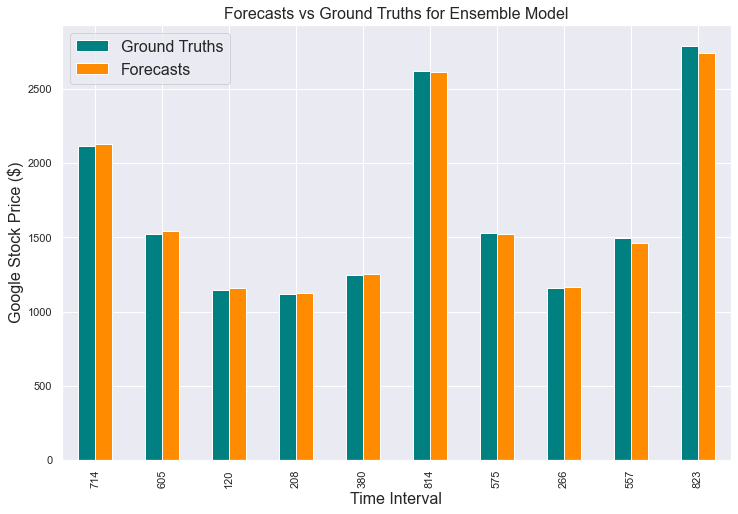

In [76]:
visually_compare(y_true = y_valid, y_pred = aggregated_model_forecast, model_name = 'Ensemble')

Let's call the function and evaluate the performance of the model.

In [77]:
model_8_df = evaluate_model_performance(y_true = y_valid, y_pred = aggregated_model_forecast, model_name = 'Ensemble')
model_8_df

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE     MSE
Ensemble Model        1.0                 1.0  1.26  18.08  26.21  686.75

Let's compare all the models.

In [78]:
models_summary = pd.concat(objs = [model_1_df, model_2_df, model_3_df, model_4_df,
                                   model_5_df, model_6_df, model_7_df, model_8_df], axis = 0)
models_summary.sort_values(by = 'MAE', inplace = True)
models_summary

R_Squared  Adjusted_R_Squared  MAPE    MAE   RMSE  \
GRU Model                       1.0                 1.0  1.25  17.91  26.02   
LSTM Model                      1.0                 1.0  1.25  17.92  26.02   
Bidirectional_GRU Model         1.0                 1.0  1.25  17.92  26.04   
Bidirectional_LSTM Model        1.0                 1.0  1.25  17.95  26.03   
Feed_Forward Model              1.0                 1.0  1.25  18.02  26.14   
Naive Forecast Model            1.0                 1.0  1.26  18.07  26.37   
Ensemble Model                  1.0                 1.0  1.26  18.08  26.21   
Conv1D Model                    1.0                 1.0  1.27  18.20  26.25   

                             MSE  
GRU Model                 677.30  
LSTM Model                677.24  
Bidirectional_GRU Model   677.92  
Bidirectional_LSTM Model  677.56  
Feed_Forward Model        683.50  
Naive Forecast Model      695.46  
Ensemble Model            686.75  
Conv1D Model              689.11

Let's define a function to make predictions on custom data.

In [79]:
def make_forecasts(input_data, model_path = None):
    """
    This is a function that makes forecasts using sliding window technique.
    
    Args:
        input_data: Seven days of historical Google stock price.
        model_path: A path to a model instance.
    
    Returns:
        Forecasts Google stock price for the next day.
    """
    model = load_model(filepath = model_path)
    data = np.array(object = [input_data], dtype = np.float32)
    forecast = tf.squeeze(input = model.predict(x = data)).numpy()
    print(f'Input: {input_data} --> Output: Google Stock Price will be {forecast:.2f} $')

Let's call the function and make a forecast for the next day's Google stock price.

In [80]:
make_forecasts(input_data = [2774.16, 2809.23, 2810.04, 2936.59, 2909.51, 2949.02, 2900.22], model_path = f'{model_5.name}.h5')

Input: [2774.16, 2809.23, 2810.04, 2936.59, 2909.51, 2949.02, 2900.22] --> Output: Google Stock Price will be 2917.52 $
